In [261]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt   
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
num_epochs = 10
k_folds = 5

transform_plain = transforms.Compose([
    transforms.ToTensor(),
])

transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
])

train_dataset_plain = datasets.CIFAR10(root='./cifar10', train=True, transform=transform_plain, download=True)
train_dataset_aug   = datasets.CIFAR10(root='./cifar10', train=True, transform=transform_augmented, download=True)
test_dataset        = datasets.CIFAR10(root='./cifar10', train=False, transform=transform_plain)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


 Visualizing Data Augmentation Examples


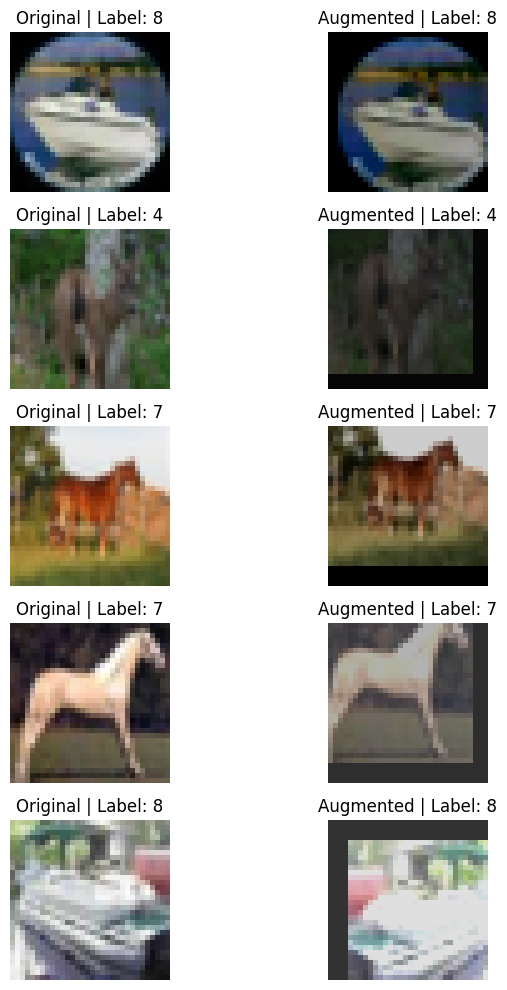

In [262]:
def visualize_augmentation(plain_dataset, aug_dataset, n=5):
    plt.figure(figsize=(8, 2 * n))

    for i in range(n):
        idx = torch.randint(0, len(plain_dataset), (1,)).item()
        img_plain, label = plain_dataset[idx]
        img_aug, _ = aug_dataset[idx]

        img_plain_np = img_plain.permute(1, 2, 0).numpy()
        img_aug_np = img_aug.permute(1, 2, 0).numpy()

        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(img_plain_np)
        plt.title(f"Original | Label: {label}")
        plt.axis('off')

        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(img_aug_np)
        plt.title(f"Augmented | Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\n Visualizing Data Augmentation Examples")
visualize_augmentation(train_dataset_plain, train_dataset_aug, n=5)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(BasicBlock, self).__init__()

        # Define convolution layers
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)

        # Adjust input channel dimension for residual connection
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        # Define batch normalization layers
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Save input for skip connection
        x_ = x

        # Convolution → BatchNorm → ReLU → Convolution → BatchNorm
        x = self.c1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.c2(x)
        x = self.bn2(x)

        # Adjust channel dimensions for residual connection
        x_ = self.downsample(x_)

        # Add skip connection and apply activation
        x += x_
        x = self.relu(x)

        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()

        # Basic residual blocks
        self.b1 = BasicBlock(in_channels=3, out_channels=64)
        self.b2 = BasicBlock(in_channels=64, out_channels=128)
        self.b3 = BasicBlock(in_channels=128, out_channels=256)

        # Use average pooling instead of max pooling
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully connected classifier
        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass through basic blocks and pooling
        x = self.b1(x)
        x = self.pool(x)
        x = self.b2(x)
        x = self.pool(x)
        x = self.b3(x)
        x = self.pool(x)

        # Flatten for fully connected layers
        x = torch.flatten(x, start_dim=1)

        # Fully connected classifier with ReLU
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x


In [265]:
# Training function
def train(model, loader, optimizer, criterion, epoch):
    model.train()   # Set the model to training mode

    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(loader):
        # Move data and target to the device
        data, target = data.to(device), target.to(device)   
        optimizer.zero_grad()               # Zero the gradients
        output = model(data)                # Forward pass
        loss = criterion(output, target)    # Compute loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights

        train_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        if batch_idx % 10 == 0:
            print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(loader.dataset),
                100. * batch_idx / len(loader), 
                loss.item()))
        
    avg_loss = train_loss / total
    accuracy = correct / total
    print(f'Train set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({100. * accuracy:.2f}%)')

In [ ]:
# Validation function 
def validate(model, loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)
            
    val_loss /= total
    val_acc = correct / total
    print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{total} '
          f'({100. * val_acc:.0f}%)')

In [ ]:
if __name__ == '__main__':
    # K-Fold Cross-Validation
    # Create K-Fold cross-validator with shuffling 
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42) 

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset_aug)):
        print(f'\n======================')
        print(f'Fold {fold + 1}/{k_folds}')
        print(f'======================')

        # Subset samplers
        train_subset = Subset(train_dataset_aug, train_idx)
        val_subset = Subset(train_dataset_aug, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Model, Optimizer, Loss
        model = ResNet().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),
                                        lr=1e-4, 
                                        betas=(0.9, 0.999),
                                        eps=1e-08,
                                        weight_decay=0,
                                        amsgrad=False)
        

        for epoch in range(num_epochs):
            print(f'\n--- Epoch {epoch + 1} ---')
            train(model, train_loader, optimizer, criterion, epoch)
            validate(model, val_loader, criterion)

    # Optional final test
    print("\n\n Final Evaluation on Test Set")
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1)
            test_correct += pred.eq(target).sum().item()
            test_total += data.size(0)

    test_loss /= test_total
    test_acc = test_correct / test_total
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {test_correct}/{test_total} ({100. * test_acc:.2f}%)')


Fold 1/5

--- Epoch 1 ---
Train Epoch: 0 | Batch Status: 0/40000 (0%) | Loss: 2.302838
Train Epoch: 0 | Batch Status: 640/40000 (2%) | Loss: 2.193197
Train Epoch: 0 | Batch Status: 1280/40000 (3%) | Loss: 2.202336
Train Epoch: 0 | Batch Status: 1920/40000 (5%) | Loss: 1.926918
Train Epoch: 0 | Batch Status: 2560/40000 (6%) | Loss: 2.076293
Train Epoch: 0 | Batch Status: 3200/40000 (8%) | Loss: 1.855039
Train Epoch: 0 | Batch Status: 3840/40000 (10%) | Loss: 1.726342
Train Epoch: 0 | Batch Status: 4480/40000 (11%) | Loss: 1.891080
Train Epoch: 0 | Batch Status: 5120/40000 (13%) | Loss: 1.744545
Train Epoch: 0 | Batch Status: 5760/40000 (14%) | Loss: 1.832740
Train Epoch: 0 | Batch Status: 6400/40000 (16%) | Loss: 1.841111
Train Epoch: 0 | Batch Status: 7040/40000 (18%) | Loss: 1.848232
Train Epoch: 0 | Batch Status: 7680/40000 (19%) | Loss: 1.573877
Train Epoch: 0 | Batch Status: 8320/40000 (21%) | Loss: 1.742858
Train Epoch: 0 | Batch Status: 8960/40000 (22%) | Loss: 1.796898
Train Ep